In [ ]:
# If you're on Colab, the built-ins usually cover torch/torchaudio.
# Uncomment if you need any of these in your environment.
!pip install -q numpy==2.2.2 librosa==0.10.2.post1 soundfile==0.12.1 matplotlib==3.9.2 \
#                 scikit-learn==1.6.1 tqdm==4.67.1 pywt==1.6.0 pandas==2.2.3
# Optional pretty model summary:
!pip install -q torchinfo

import os, sys, json, glob, shutil, tarfile, zipfile, subprocess, hashlib, random
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm import tqdm

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score

plt.rcParams["figure.dpi"] = 140  # nicer plots
print("Imports ready.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires numba<0.62.0a0,>=0.59.1, but you have numba 0.62.1 which is incompatible.
cuml-cu12 25.6.0 requires numba<0.62.0a0,>=0.59.1, but you have numba 0.62.1 which is incompatible.
dask-cuda 25.6.0 requires numba<0.62.0a0,>=0.59.1, but you have numba 0.62.

In [ ]:
CFG = {
    "root": "/content/UrbanSound8K",
    "metadata_csv": "metadata/UrbanSound8K.csv",
    "folds_dir": "audio",

    # classes (auto + confusers)
    "classes": ["car_horn","engine_idling","siren","dog_bark","drilling","street_music"],

    # audio/features
    "sr": 22050,
    "clip_seconds": 4.0,
    "n_mels": 64,
    "n_fft": 1024,
    "hop_length": 256,

    # training
    "batch_size": 64,
    "epochs": 30,
    "lr": 2e-3,
    "weight_decay": 1e-4,
    "seed": 1337,
    "num_workers": 2,

    # speed control
    "fast_mode": False,              # <— set to False for final full run
    "fast_cap_per_class": 400,

    # research toggles
    "use_wiener": False,
    "use_modspec": True,
    "use_lpc": True,
    "specaugment": True,
    "model": "cnn_bilstm",  # "tinycnn" or "cnn_bilstm"

    # cache/outputs
    "cache_dir": "/content/us8k_cache",
    "out_dir": "/content/outputs",
}

# Determinism
random.seed(CFG["seed"]); np.random.seed(CFG["seed"]); torch.manual_seed(CFG["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
Path(CFG["cache_dir"]).mkdir(parents=True, exist_ok=True)
Path(CFG["out_dir"]).mkdir(parents=True, exist_ok=True)

root = Path(CFG["root"])
meta_path = root / CFG["metadata_csv"]

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

print("Config OK.")


Config OK.


In [ ]:
def _already_present() -> bool:
    return meta_path.exists()

def _try_wget(url: str, out: Path) -> bool:
    try:
        print(f"Attempting download: {url}")
        ret = subprocess.run(["wget", "-q", "--show-progress", "-O", str(out), url])
        return ret.returncode == 0 and out.exists() and out.stat().st_size > 10_000_000
    except Exception as e:
        print("wget error:", e)
        return False

def _extract_archive(archive_path: Path, dest: Path):
    if archive_path.suffixes[-2:] == ['.tar', '.gz'] or archive_path.suffix == ".tgz":
        with tarfile.open(archive_path, 'r:gz') as tar:
            tar.extractall(dest)
    elif archive_path.suffix == ".zip":
        with zipfile.ZipFile(archive_path, 'r') as z:
            z.extractall(dest)
    else:
        raise ValueError(f"Unknown archive type: {archive_path}")

def ensure_dataset():
    if _already_present():
        print("✅ Found UrbanSound8K; skipping download.")
        return
    print("UrbanSound8K not found. Trying mirrors…")
    dl_dir = Path("/content/_dl"); dl_dir.mkdir(exist_ok=True, parents=True)
    archive = dl_dir / "UrbanSound8K.tar.gz"
    mirrors = [
        "https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz?download=1",
        "https://urbansounddataset.weebly.com/uploads/5/3/6/2/5362550/urbansound8k.tar.gz",
    ]
    ok = False
    for url in mirrors:
        if _try_wget(url, archive):
            ok = True
            break
    if not ok:
        print("\n❗ Mirror download failed. Download manually and place under /content")
        print("   Official: https://urbansounddataset.weebly.com/urbansound8k.html")
        raise SystemExit
    print("Extracting…")
    _extract_archive(archive, Path("/content"))
    # Normalize structure if nested
    if not (root / "metadata/UrbanSound8K.csv").exists():
        candidates = list(Path("/content").glob("**/UrbanSound8K/metadata/UrbanSound8K.csv"))
        if len(candidates):
            found_root = candidates[0].parents[1]
            if str(found_root) != str(root):
                shutil.move(str(found_root), str(root))
    print("✅ Dataset ready.")

ensure_dataset()


✅ Found UrbanSound8K; skipping download.


In [ ]:
class US8KSubset(Dataset):
    def __init__(self, df: pd.DataFrame, cfg: Dict):
        self.df = df.reset_index(drop=True)
        self.cfg = cfg
        self.sr = cfg["sr"]
        self.clip_len = int(cfg["clip_seconds"] * self.sr)
        self.melspec_cache = Path(cfg["cache_dir"]) / "mels"
        self.melspec_cache.mkdir(parents=True, exist_ok=True)

    def __len__(self): return len(self.df)

    def _cache_key(self, wav_path: str) -> Path:
        h = hashlib.sha1(str(wav_path).encode()).hexdigest()[:16]
        return self.melspec_cache / f"{h}.npy"

    def _apply_wiener(self, y: np.ndarray) -> np.ndarray:
        S = librosa.stft(y, n_fft=self.cfg["n_fft"], hop_length=self.cfg["hop_length"], window="hann")
        mag, phase = np.abs(S), np.angle(S)
        noise = np.percentile(mag, 10, axis=1, keepdims=True)
        gain = (mag**2) / (mag**2 + noise**2 + 1e-9)
        Sout = gain * mag * np.exp(1j * phase)
        y_hat = librosa.istft(Sout, hop_length=self.cfg["hop_length"], window="hann", length=len(y))
        return y_hat

    def _load_clip(self, path: str) -> np.ndarray:
        y, sr = librosa.load(path, sr=self.sr, mono=True)
        if len(y) < self.clip_len:
            y = np.pad(y, (0, self.clip_len - len(y)))
        else:
            y = y[:self.clip_len]
        return y

    def _wav_to_mel(self, y: np.ndarray) -> np.ndarray:
        if self.cfg.get("use_wiener", False):
            y = self._apply_wiener(y)
        S = librosa.feature.melspectrogram(
            y=y, sr=self.sr, n_fft=self.cfg["n_fft"], hop_length=self.cfg["hop_length"],
            n_mels=self.cfg["n_mels"], power=2.0
        )
        S_db = librosa.power_to_db(S, ref=np.max)
        mu, sigma = S_db.mean(), S_db.std() + 1e-6
        S_norm = (S_db - mu) / sigma
        return S_norm.astype(np.float32)

    def __getitem__(self, idx: int):
        r = self.df.iloc[idx]
        path = r.get("path", os.path.join(self.cfg["root"], self.cfg["folds_dir"], f"fold{r.fold}", r.slice_file_name))
        label = int(r["target"])

        ck = self._cache_key(path)
        if os.path.exists(ck):
            mel = np.load(ck)
        else:
            y = self._load_clip(path)
            mel = self._wav_to_mel(y)
            np.save(ck, mel)

        # Auxiliary features (ZCR/RMS/ModSpec/LPC)
        y0 = self._load_clip(path)
        zcr = librosa.feature.zero_crossing_rate(y0, frame_length=self.cfg["n_fft"], hop_length=self.cfg["hop_length"]).mean()
        rms = librosa.feature.rms(y=y0, frame_length=self.cfg["n_fft"], hop_length=self.cfg["hop_length"]).mean()
        feats = [float(zcr), float(rms)]

        if self.cfg.get("use_modspec", True):
            Sm = librosa.feature.melspectrogram(y=y0, sr=self.sr, n_fft=512, hop_length=128, n_mels=32, power=2.0)
            Sm = librosa.power_to_db(Sm, ref=np.max); Sm = (Sm - Sm.mean())/(Sm.std()+1e-6)
            ph, pw = 8, 8; acc = []; H, W = Sm.shape
            for i in range(0, H - ph + 1, ph):
                for j in range(0, W - pw + 1, pw):
                    P = Sm[i:i + ph, j:j + pw]; F = np.abs(np.fft.fft2(P)); acc.append(F)
            Fmean = np.mean(acc, axis=0) if acc else np.zeros((ph, pw))
            feats += np.sort(Fmean.ravel())[-20:].tolist()

        if self.cfg.get("use_lpc", True):
            try:    lpc = librosa.lpc(y0, order=10).tolist()
            except: lpc = [0.0] * 11
            feats += [float(x) for x in lpc]

        mel = torch.from_numpy(mel)[None, ...]
        aux = torch.tensor([feats], dtype=torch.float32)
        return (mel, aux), torch.tensor(label, dtype=torch.long)

print("Dataset class ready.")


Dataset class ready.


Split sizes: 4346 503 509


/tmp/ipython-input-1648218253.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title("Train class counts"); ax.set_xticklabels(counts.index, rotation=30, ha='right')


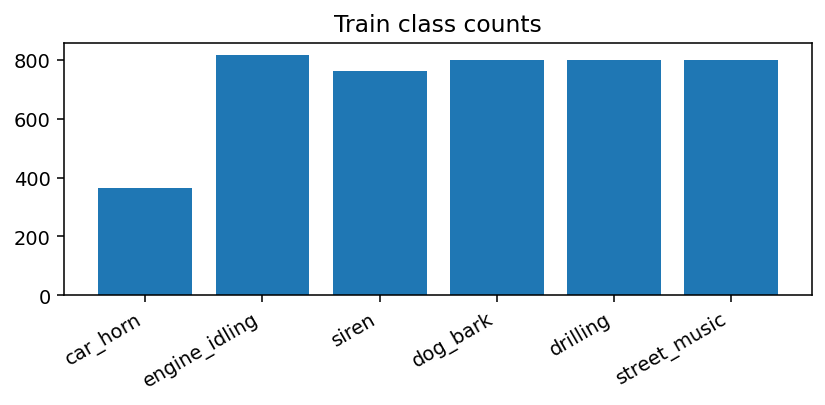

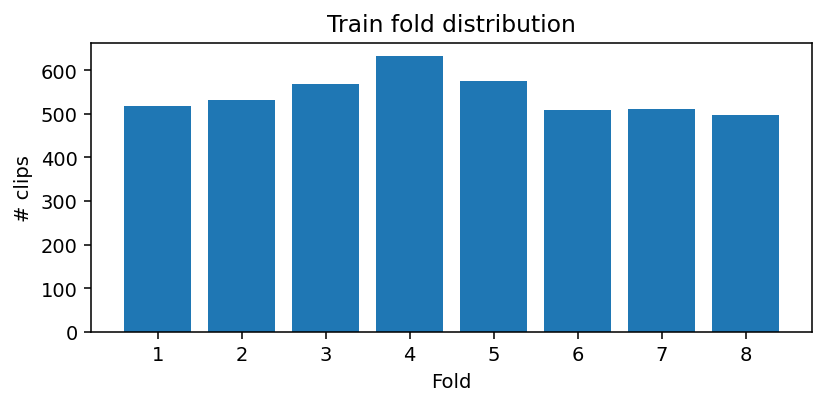

In [ ]:
meta = pd.read_csv(meta_path)
meta["fname"] = meta["slice_file_name"]
meta["fold_path"] = meta["fold"].apply(lambda f: str(Path(CFG["root"]) / CFG["folds_dir"] / f"fold{f}"))
meta["path"] = meta.apply(lambda r: str(Path(r["fold_path"]) / r["fname"]), axis=1)

label2id = {c: i for i, c in enumerate(sorted(CFG["classes"]))}
id2label = {v:k for k,v in label2id.items()}

def build_splits(meta: pd.DataFrame, label2id: Dict[str,int]):
    FOLDS = list(range(1, 11))
    test_fold, val_fold = 10, 9
    train_folds = [f for f in FOLDS if f not in (test_fold, val_fold)]

    keep = meta[meta["class"].isin(CFG["classes"])].copy()
    keep["target"] = keep["class"].map(label2id)

    train_df = keep[keep["fold"].isin(train_folds)].reset_index(drop=True)
    val_df   = keep[keep["fold"] == val_fold].reset_index(drop=True)
    test_df  = keep[keep["fold"] == test_fold].reset_index(drop=True)

    def cap_per_class(df, cap):
        if not cap: return df
        out = []
        for c in CFG["classes"]:
            dfc = df[df["class"] == c]
            n = min(cap, len(dfc))
            out.append(dfc.sample(n=n, random_state=CFG["seed"]) if n > 0 else dfc)
        return pd.concat(out).sample(frac=1.0, random_state=CFG["seed"]).reset_index(drop=True)

    if CFG["fast_mode"]:
        train_df = cap_per_class(train_df, CFG["fast_cap_per_class"])
        val_df   = cap_per_class(val_df, min(200, CFG["fast_cap_per_class"]))

    return train_df, val_df, test_df

train_df, val_df, test_df = build_splits(meta, label2id)
print("Split sizes:", len(train_df), len(val_df), len(test_df))

# Class counts
fig, ax = plt.subplots(figsize=(6,3))
counts = train_df['class'].value_counts().reindex(CFG["classes"])
ax.bar(counts.index, counts.values)
ax.set_title("Train class counts"); ax.set_xticklabels(counts.index, rotation=30, ha='right')
plt.tight_layout(); plt.show()

# Fold distribution
fig, ax = plt.subplots(figsize=(6,3))
fold_counts = train_df['fold'].value_counts().sort_index()
ax.bar(fold_counts.index, fold_counts.values)
ax.set_title("Train fold distribution"); ax.set_xlabel("Fold"); ax.set_ylabel("# clips")
plt.tight_layout(); plt.show()


In [ ]:
class TinyCNNWithAux(nn.Module):
    def __init__(self, n_mels: int, n_classes: int, aux_dim: int):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.head = nn.Sequential(
            nn.Linear(64 + aux_dim, 192), nn.ReLU(), nn.Dropout(0.25),
            nn.Linear(192, n_classes)
        )
    def forward(self, mel, aux):
        x = self.feat(mel)
        x = self.gap(x).squeeze(-1).squeeze(-1)
        x = torch.cat([x, aux.squeeze(1)], dim=1)
        return self.head(x)

class CNNBiLSTM(nn.Module):
    def __init__(self, n_mels: int, n_classes: int, aux_dim: int):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.proj = nn.Linear((n_mels//4)*64, 128)
        self.rnn  = nn.LSTM(128, 96, batch_first=True, bidirectional=True)
        self.fc   = nn.Sequential(
            nn.Linear(96*2 + aux_dim, 192), nn.ReLU(), nn.Dropout(0.25),
            nn.Linear(192, n_classes)
        )
    def forward(self, mel, aux):
        x = self.cnn(mel)              # B, C, H, W
        B,C,H,W = x.shape
        x = x.permute(0,3,1,2).contiguous().view(B, W, C*H)  # B, T, F
        x,_ = self.rnn(self.proj(x))   # B, T, 2*96
        x = x.mean(1)                  # temporal mean
        x = torch.cat([x, aux.squeeze(1)], dim=1)
        return self.fc(x)

print("Models ready.")


Models ready.


In [ ]:
def spec_augment(mel, time_masks=1, freq_masks=1, max_t=24, max_f=8):
    if not CFG.get("specaugment", True):
        return mel
    B,_,F,T = mel.shape
    m = mel.clone()
    for _ in range(freq_masks):
        f = np.random.randint(0, max_f+1)
        f0 = np.random.randint(0, max(1, F-f))
        m[:,:,f0:f0+f,:] = 0
    for _ in range(time_masks):
        t = np.random.randint(0, max_t+1)
        t0 = np.random.randint(0, max(1, T-t))
        m[:,:,:,t0:t0+t] = 0
    return m

class EarlyStopper:
    def __init__(self, patience=6, mode='max'):
        self.patience = patience
        self.mode = mode
        self.best = None
        self.count = 0
    def step(self, value):
        if self.best is None:
            self.best = value; self.count = 0; return False
        improve = (value > self.best) if self.mode=='max' else (value < self.best)
        if improve:
            self.best = value; self.count = 0; return False
        self.count += 1
        return self.count > self.patience

def save_confusion(cm: np.ndarray, labels: List[str], out_png: Path, out_csv: Path):
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title("Confusion Matrix"); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right'); ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout(); fig.savefig(out_png, dpi=160); plt.close(fig)
    pd.DataFrame(cm, index=labels, columns=labels).to_csv(out_csv)

print("Training utils ready.")


Training utils ready.


In [ ]:
train_ds = US8KSubset(train_df, CFG)
val_ds   = US8KSubset(val_df, CFG)
test_ds  = US8KSubset(test_df, CFG)

train_dl = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True,  num_workers=CFG["num_workers"], pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"], pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"], pin_memory=True)

# Infer aux feature size using one sample
tmp = DataLoader(train_ds, batch_size=1, shuffle=False)
(mel_chk, aux_chk), _ = next(iter(tmp))
aux_dim = aux_chk.shape[-1]
print("Inferred aux_dim:", aux_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if CFG.get("model","cnn_bilstm") == "cnn_bilstm":
    model = CNNBiLSTM(CFG["n_mels"], n_classes=len(label2id), aux_dim=aux_dim).to(device)
else:
    model = TinyCNNWithAux(CFG["n_mels"], n_classes=len(label2id), aux_dim=aux_dim).to(device)

# --- Model structure (Option A: no dependencies) ---
def count_params(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

print(model)  # module tree
total, trainable = count_params(model)
print(f"\nParameter count: trainable={trainable:,} / total={total:,}")

with torch.no_grad():
    mel_sample = mel_chk.to(device).float()
    aux_sample = aux_chk.to(device).float()
    out = model(mel_sample, aux_sample)
    print("Input mel shape:", tuple(mel_sample.shape))
    print("Input aux shape:", tuple(aux_sample.shape))
    print("Output logits shape:", tuple(out.shape))

# --- Pretty model table (Option B: torchinfo, optional) ---
try:
    from torchinfo import summary
    summary(
        model,
        input_data=(mel_chk.to(device).float(), aux_chk.to(device).float()),
        col_names=("input_size","output_size","num_params","kernel_size","mult_adds"),
        depth=3,
        verbose=1
    )
except Exception as e:
    print("(torchinfo not installed or failed) -> skipping pretty summary.")


Inferred aux_dim: 33
CNNBiLSTM(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (proj): Linear(in_features=1024, out_features=128, bias=True)
  (rnn): LSTM(128, 96, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=225, out_features=192, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=192, out_features=6, bias=True)
  )
)

Parameter count: trainable=368,326 / total=368,326
Input mel shape: (1, 1, 64, 345)
In

In [ ]:
opt = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
stopper = EarlyStopper(patience=6, mode='max')
best_val_f1 = -1.0
hist_rows = []

def run_epoch(model, loader, device, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    total, correct, loss_sum = 0, 0, 0.0
    y_true, y_pred = [], []
    crit = nn.CrossEntropyLoss()
    for (mel, aux), yb in loader:
        mel = mel.to(device, non_blocking=True).float()
        aux = aux.to(device, non_blocking=True).float()
        yb  = yb.to(device, non_blocking=True).long()
        if is_train:
            optimizer.zero_grad()
            mel = spec_augment(mel)
        logits = model(mel, aux)
        loss = crit(logits, yb)
        if is_train:
            loss.backward(); optimizer.step()
        pred = logits.argmax(1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()
        loss_sum += loss.item() * yb.size(0)
        y_true.extend(yb.detach().cpu().tolist())
        y_pred.extend(pred.detach().cpu().tolist())
    acc = correct/total
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return loss_sum/total, acc, macro_f1

for ep in range(1, CFG["epochs"]+1):
    tr_loss, tr_acc, tr_f1 = run_epoch(model, train_dl, device, optimizer=opt)
    va_loss, va_acc, va_f1 = run_epoch(model, val_dl, device, optimizer=None)
    hist_rows.append({"epoch": ep, "train_loss": tr_loss, "train_acc": tr_acc, "train_f1": tr_f1,
                      "val_loss": va_loss, "val_acc": va_acc, "val_f1": va_f1})
    print(f"Epoch {ep:02d} | train: loss={tr_loss:.4f} acc={tr_acc:.3f} f1={tr_f1:.3f}  "
          f"| val: loss={va_loss:.4f} acc={va_acc:.3f} f1={va_f1:.3f}")
    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        torch.save(model.state_dict(), f"{CFG['out_dir']}/best.pt")
    if stopper.step(va_f1):
        print("Early stopping triggered.")
        break

pd.DataFrame(hist_rows).to_csv(f"{CFG['out_dir']}/training_log.csv", index=False)
print("Saved:", f"{CFG['out_dir']}/training_log.csv")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train: loss=49723415.2029 acc=0.491 f1=0.454  | val: loss=37.4064 acc=0.700 f1=0.605


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 02 | train: loss=599322921.8134 acc=0.676 f1=0.651  | val: loss=10.2419 acc=0.718 f1=0.694


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 03 | train: loss=82960.5671 acc=0.746 f1=0.734  | val: loss=9.7092 acc=0.781 f1=0.772


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 04 | train: loss=355409.7723 acc=0.763 f1=0.755  | val: loss=17.8926 acc=0.684 f1=0.666


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 05 | train: loss=3922.3519 acc=0.793 f1=0.785  | val: loss=44.9154 acc=0.763 f1=0.764


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 06 | train: loss=259133132.5533 acc=0.812 f1=0.800  | val: loss=26.2020 acc=0.787 f1=0.771


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 07 | train: loss=3112883.3478 acc=0.820 f1=0.816  | val: loss=24.9158 acc=0.801 f1=0.789


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 08 | train: loss=253890.0357 acc=0.827 f1=0.824  | val: loss=22.1361 acc=0.787 f1=0.798


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 09 | train: loss=214544.9612 acc=0.841 f1=0.836  | val: loss=42.5150 acc=0.746 f1=0.761


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10 | train: loss=152704.2871 acc=0.829 f1=0.825  | val: loss=76.9169 acc=0.767 f1=0.756


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11 | train: loss=53089.1099 acc=0.829 f1=0.821  | val: loss=142.3770 acc=0.817 f1=0.817


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12 | train: loss=930059839.9636 acc=0.848 f1=0.842  | val: loss=144.6907 acc=0.837 f1=0.836


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 13 | train: loss=626474.2025 acc=0.858 f1=0.853  | val: loss=50.4407 acc=0.819 f1=0.827


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 14 | train: loss=476106.7433 acc=0.852 f1=0.846  | val: loss=47.2218 acc=0.821 f1=0.815


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 15 | train: loss=641251.0474 acc=0.876 f1=0.875  | val: loss=52.9069 acc=0.817 f1=0.809


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 16 | train: loss=521495.5289 acc=0.864 f1=0.860  | val: loss=77.6258 acc=0.833 f1=0.833


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 17 | train: loss=986600.4163 acc=0.850 f1=0.841  | val: loss=119.0305 acc=0.797 f1=0.790


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 18 | train: loss=541185.2467 acc=0.861 f1=0.858  | val: loss=147.3171 acc=0.793 f1=0.787


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 19 | train: loss=353488.4098 acc=0.859 f1=0.854  | val: loss=192.9226 acc=0.821 f1=0.829
Early stopping triggered.
Saved: /content/outputs/training_log.csv


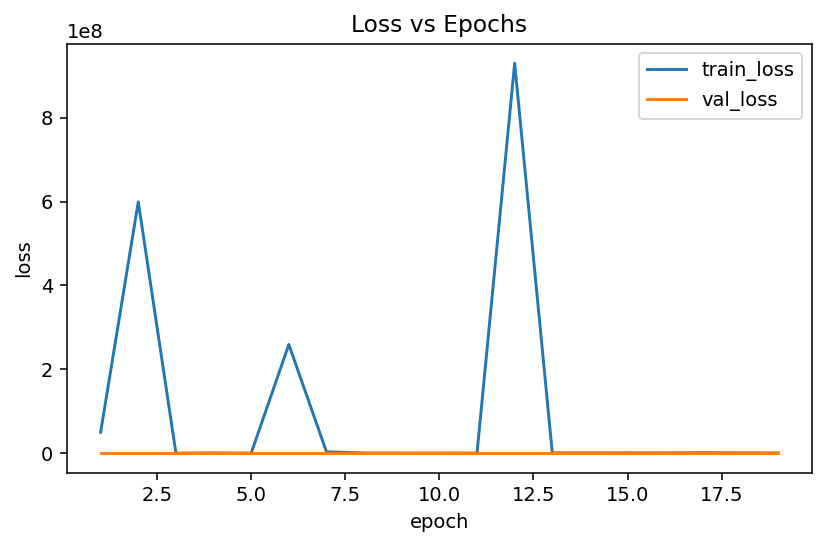

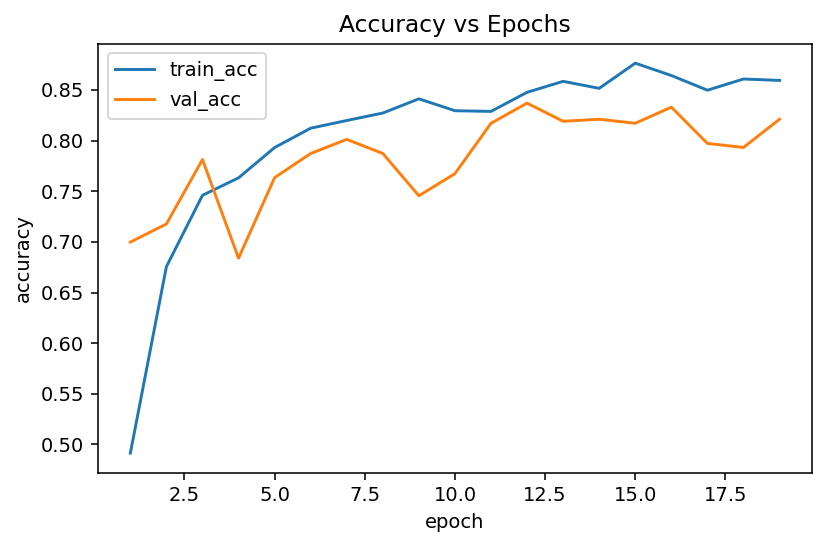

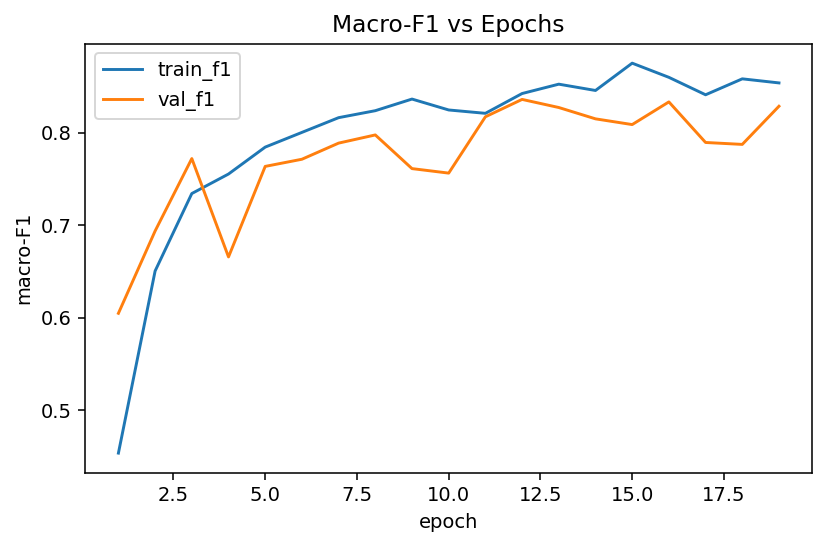

In [ ]:
log_csv = Path(CFG['out_dir'])/"training_log.csv"
df = pd.read_csv(log_csv)

def _plot_metric(df, cols, title, ylabel, out_png):
    fig, ax = plt.subplots(figsize=(6,4))
    for c in cols:
        ax.plot(df['epoch'], df[c], label=c)
    ax.set_xlabel('epoch'); ax.set_ylabel(ylabel); ax.set_title(title); ax.legend()
    plt.tight_layout(); fig.savefig(out_png, dpi=160); plt.show(); plt.close(fig)

_plot_metric(df, ['train_loss','val_loss'], 'Loss vs Epochs', 'loss', Path(CFG['out_dir'])/'plot_loss.png')
_plot_metric(df, ['train_acc','val_acc'], 'Accuracy vs Epochs', 'accuracy', Path(CFG['out_dir'])/'plot_accuracy.png')
_plot_metric(df, ['train_f1','val_f1'],   'Macro-F1 vs Epochs', 'macro-F1', Path(CFG['out_dir'])/'plot_macro_f1.png')


In [ ]:
# Load best
model.load_state_dict(torch.load(f"{CFG['out_dir']}/best.pt", map_location=device))
model.eval()

all_y, all_p = [], []
with torch.no_grad():
    for (mel, aux), yb in test_dl:
        mel = mel.to(device).float(); aux = aux.to(device).float()
        logits = model(mel, aux)
        preds = logits.argmax(1).cpu().numpy().tolist()
        all_p += preds; all_y += yb.numpy().tolist()

labels_in_order = [k for k,_ in sorted(label2id.items(), key=lambda x:x[1])]
report = classification_report(all_y, all_p, target_names=labels_in_order, output_dict=True)
macro_f1_test = f1_score(all_y, all_p, average='macro')
cm = confusion_matrix(all_y, all_p)

with open(f"{CFG['out_dir']}/metrics.json", "w") as f:
    json.dump({"test_macro_f1": macro_f1_test, "test_report": report}, f, indent=2)

save_confusion(cm, labels_in_order,
               out_png=Path(CFG['out_dir'])/"confusion_matrix.png",
               out_csv=Path(CFG['out_dir'])/"confusion_matrix.csv")

print(f"Test macro-F1: {macro_f1_test:.3f}")
pd.DataFrame(report).T  # pretty per-class table inline


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test macro-F1: 0.781


,precision,recall,f1-score,support
car_horn,0.878788,0.878788,0.878788,33.000000
dog_bark,0.660870,0.760000,0.706977,100.000000
drilling,0.760000,0.760000,0.760000,100.000000
engine_idling,0.902174,0.892473,0.897297,93.000000
siren,0.745455,0.493976,0.594203,83.000000
street_music,0.798246,0.910000,0.850467,100.000000
accuracy,0.777996,0.777996,0.777996,0.777996
macro avg,0.790922,0.782539,0.781289,509.000000
weighted avg,0.779345,0.777996,0.773108,509.000000


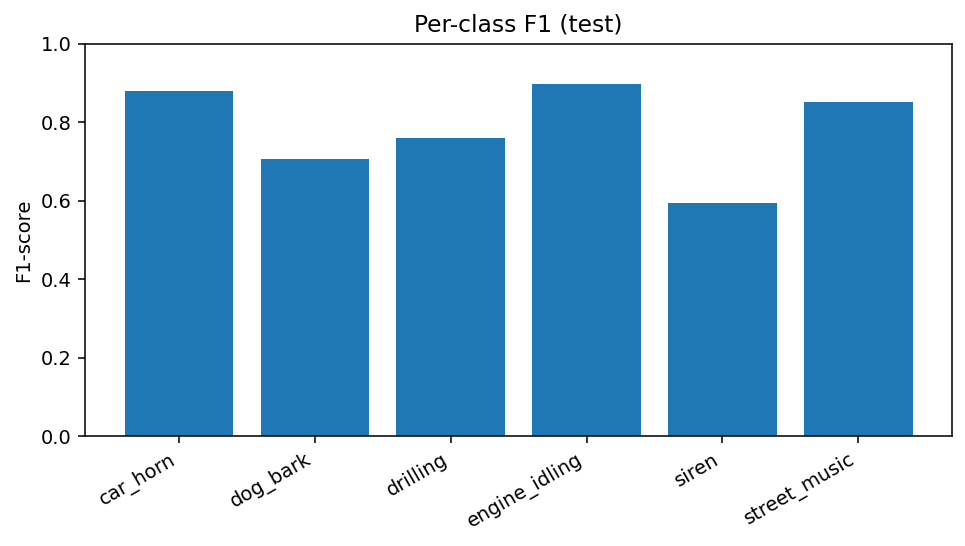

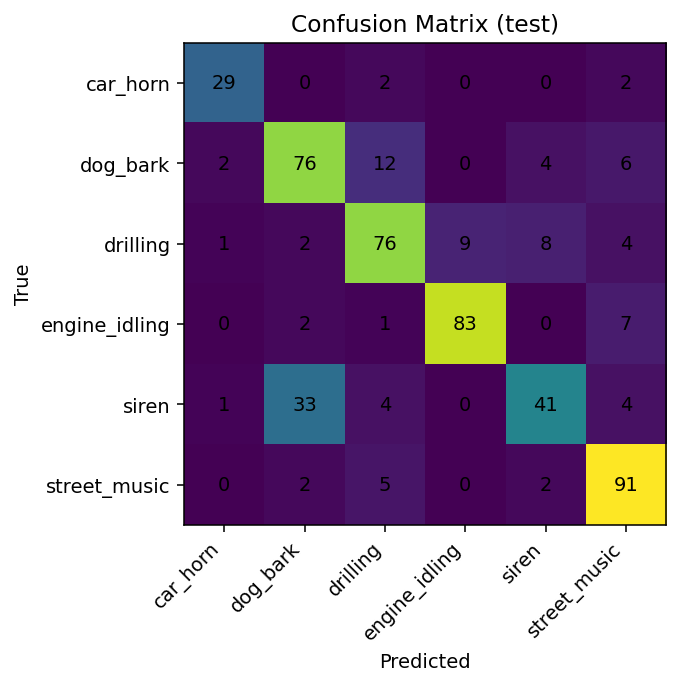

In [ ]:
# Per-class F1 bar
classes, f1s = [], []
for cls, stats in report.items():
    if isinstance(stats, dict) and 'f1-score' in stats and cls not in ('accuracy','macro avg','weighted avg'):
        classes.append(cls); f1s.append(stats['f1-score'])

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(range(len(classes)), f1s)
ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes, rotation=30, ha='right')
ax.set_ylim(0,1); ax.set_ylabel('F1-score'); ax.set_title('Per-class F1 (test)')
plt.tight_layout(); plt.savefig(Path(CFG['out_dir'])/'plot_per_class_f1.png', dpi=160)
plt.show()

# Confusion matrix inline
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix (test)"); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(len(labels_in_order))); ax.set_yticks(range(len(labels_in_order)))
ax.set_xticklabels(labels_in_order, rotation=45, ha='right'); ax.set_yticklabels(labels_in_order)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()


In [ ]:
# ============================
# Showcase & Mistakes — SAFE VERSION (run AFTER training)
# ============================

from pathlib import Path
import numpy as np, pandas as pd, torch, librosa, json, os
from torch.utils.data import DataLoader

# --- helper to ensure folders exist ---
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

# --- HOTFIX: safer __getitem__ for US8KSubset (handles rows with only "path"/"target") ---
def _subset_getitem(self, idx: int):
    r = self.df.iloc[idx]

    # Use explicit column check (Series.index), not value membership.
    if ('path' in r.index) and isinstance(r['path'], (str, bytes)):
        path = r['path']
    else:
        # Expect UrbanSound8K metadata columns present
        fold = int(r['fold'])
        fname = r['slice_file_name']
        path = os.path.join(self.cfg["root"], self.cfg["folds_dir"], f"fold{fold}", fname)

    label = int(r['target']) if 'target' in r.index else 0  # default safe label for inference rows

    # mel (cached)
    ck = self._cache_key(path)
    if os.path.exists(ck):
        mel = np.load(ck)
    else:
        y = self._load_clip(path)
        mel = self._wav_to_mel(y)
        np.save(ck, mel)

    # auxiliary features
    y0 = self._load_clip(path)
    zcr = librosa.feature.zero_crossing_rate(
        y0, frame_length=self.cfg["n_fft"], hop_length=self.cfg["hop_length"]
    ).mean()
    rms = librosa.feature.rms(
        y=y0, frame_length=self.cfg["n_fft"], hop_length=self.cfg["hop_length"]
    ).mean()
    feats = [float(zcr), float(rms)]

    if self.cfg.get("use_modspec", True):
        Sm = librosa.feature.melspectrogram(
            y=y0, sr=self.sr, n_fft=512, hop_length=128, n_mels=32, power=2.0
        )
        Sm = librosa.power_to_db(Sm, ref=np.max)
        Sm = (Sm - Sm.mean())/(Sm.std()+1e-6)
        ph, pw = 8, 8
        acc = []
        H, W = Sm.shape
        for i in range(0, H - ph + 1, ph):
            for j in range(0, W - pw + 1, pw):
                P = Sm[i:i + ph, j:j + pw]
                F = np.abs(np.fft.fft2(P))
                acc.append(F)
        Fmean = np.mean(acc, axis=0) if acc else np.zeros((ph, pw))
        feats += np.sort(Fmean.ravel())[-20:].tolist()

    if self.cfg.get("use_lpc", True):
        try:
            lpc = librosa.lpc(y0, order=10).tolist()
        except Exception:
            lpc = [0.0] * 11
        feats += [float(x) for x in lpc]

    mel = torch.from_numpy(mel)[None, ...]
    aux = torch.tensor([feats], dtype=torch.float32)
    return (mel, aux), torch.tensor(label, dtype=torch.long)

# Monkey-patch the class (assumes US8KSubset already defined earlier)
US8KSubset.__getitem__ = _subset_getitem
print("✅ Patched US8KSubset.__getitem__")

# --- Plot/save a mel spectrogram image for a given waveform ---
import matplotlib.pyplot as plt
import librosa.display
def _plot_and_save_mel(y: np.ndarray, sr: int, out_png: Path, title: str="Log-mel"):
    ensure_dir(out_png.parent)
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=CFG["n_fft"], hop_length=CFG["hop_length"],
        n_mels=CFG["n_mels"], power=2.0
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    fig, ax = plt.subplots(figsize=(5.0, 3.0))
    img = librosa.display.specshow(S_db, sr=sr, hop_length=CFG["hop_length"],
                                   x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(title)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    plt.tight_layout()
    fig.savefig(out_png, dpi=160)
    plt.close(fig)

# --- Single-file prediction using current model ---
def _predict_raw(model, device, wav_path: str, id2label: dict) -> tuple[str, dict]:
    ds = US8KSubset(pd.DataFrame([{ "path": wav_path, "target": 0 }]), CFG)
    (mel, aux), _ = ds[0]
    with torch.no_grad():
        logits = model(
            mel.unsqueeze(0).to(device).float(),
            aux.unsqueeze(0).to(device).float()
        )
        p = logits.softmax(1).cpu().numpy()[0]
    pred_idx = int(np.argmax(p))
    pred = id2label[pred_idx]
    probs = {id2label[i]: float(p[i]) for i in range(len(p))}
    return pred, probs

# --- Showcase examples (val/test) ---
def showcase_examples(model, device, df: pd.DataFrame, label2id: dict, split_name="val", k=2):
    id2label = {v:k for k,v in label2id.items()}
    out_dir = Path(CFG['out_dir'])/"examples"/split_name
    ensure_dir(out_dir)
    rows = []
    for cls in sorted(label2id.keys()):
        sdf = df[df["class"]==cls]
        if len(sdf)==0:
            continue
        picks = sdf.sample(n=min(k, len(sdf)), random_state=CFG["seed"]).reset_index(drop=True)
        for _, r in picks.iterrows():
            wav = r["path"]
            y, sr = librosa.load(wav, sr=CFG["sr"])
            pred, probs = _predict_raw(model, device, wav, id2label)
            spec_path = out_dir/f"{Path(wav).stem}__{cls}__pred-{pred}.png"
            _plot_and_save_mel(y, sr, spec_path, title=f"{split_name} • {cls} → {pred}")
            rows.append({
                "split": split_name,
                "file": os.path.basename(wav),
                "path": wav,
                "true": cls,
                "pred": pred,
                "top1_prob": float(max(probs.values())),
                "probs_json": json.dumps(probs),
                "spectrogram_png": str(spec_path)
            })
    if rows:
        pd.DataFrame(rows).to_csv(out_dir/"examples_inputs_outputs.csv", index=False)
    print(f"✅ Saved examples for {split_name} →", out_dir)

# --- Showcase first K mistakes on the test set ---
def showcase_mistakes(model, device, df: pd.DataFrame, label2id: dict, k=4):
    id2label = {v:k for k,v in label2id.items()}
    out_dir = Path(CFG['out_dir'])/"examples"/"test_mistakes"
    ensure_dir(out_dir)
    ds = US8KSubset(df, CFG)
    dl = DataLoader(ds, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"])
    mistakes, base = [], 0
    model.eval()
    with torch.no_grad():
        for (mel, aux), yb in dl:
            mel, aux = mel.to(device).float(), aux.to(device).float()
            logits = model(mel, aux)
            preds = logits.argmax(1).cpu()
            yb_cpu = yb.cpu()
            for j in range(len(yb_cpu)):
                if preds[j].item() != yb_cpu[j].item():
                    row = df.iloc[base + j]
                    wav = row["path"]
                    true_c = id2label[int(yb_cpu[j].item())]
                    pred_c = id2label[int(preds[j].item())]
                    y, sr = librosa.load(wav, sr=CFG["sr"])
                    spec_path = out_dir/f"{Path(wav).stem}__true-{true_c}__pred-{pred_c}.png"
                    _plot_and_save_mel(y, sr, spec_path, title=f"mistake • true: {true_c} → pred: {pred_c}")
                    mistakes.append({
                        "file": os.path.basename(wav),
                        "path": wav,
                        "true": true_c,
                        "pred": pred_c,
                        "spectrogram_png": str(spec_path)
                    })
                    if len(mistakes) >= k:
                        break
            base += len(yb_cpu)
            if len(mistakes) >= k:
                break
    if mistakes:
        pd.DataFrame(mistakes).to_csv(out_dir/"mistakes_examples.csv", index=False)
    print(f"✅ Saved first {len(mistakes)} mistakes →", out_dir)

# ---------- RUN (assumes: model, device, val_df, test_df, label2id, CFG exist from earlier cells) ----------
showcase_examples(model, device, val_df,  label2id, split_name="val",  k=2)
showcase_examples(model, device, test_df, label2id, split_name="test", k=2)
showcase_mistakes(model, device, test_df, label2id, k=4)


✅ Patched US8KSubset.__getitem__
✅ Saved examples for val → /content/outputs/examples/val
✅ Saved examples for test → /content/outputs/examples/test
✅ Saved first 4 mistakes → /content/outputs/examples/test_mistakes


In [ ]:
def _wiener_like(y: np.ndarray) -> np.ndarray:
    S = librosa.stft(y, n_fft=CFG["n_fft"], hop_length=CFG["hop_length"], window="hann")
    mag, phase = np.abs(S), np.angle(S)
    noise = np.percentile(mag, 10, axis=1, keepdims=True)
    gain = (mag**2) / (mag**2 + noise**2 + 1e-9)
    Sout = gain * mag * np.exp(1j * phase)
    y_hat = librosa.istft(Sout, hop_length=CFG["hop_length"], window="hann", length=len(y))
    return y_hat.astype(np.float32)

def _mel_reconstruct(y: np.ndarray, sr: int) -> np.ndarray:
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=CFG["n_fft"], hop_length=CFG["hop_length"], n_mels=CFG["n_mels"], power=2.0
    )
    y_rec = librosa.feature.inverse.mel_to_audio(
        M=S, sr=sr, n_fft=CFG["n_fft"], hop_length=CFG["hop_length"], power=2.0
    )
    return y_rec.astype(np.float32)

def _safe_write(path: Path, y: np.ndarray, sr: int):
    y = np.asarray(y, dtype=np.float32)
    peak = float(np.max(np.abs(y)) + 1e-9)
    if peak > 1.0:
        y = y / peak
    sf.write(path, y, sr)

def export_audio_pairs(per_class: int = 1):
    base = Path(CFG['out_dir']) / "examples"
    val_csv  = base / "val"  / "examples_inputs_outputs.csv"
    test_csv = base / "test" / "examples_inputs_outputs.csv"
    out_dir = base / "audio_pairs"
    out_dir.mkdir(parents=True, exist_ok=True)

    def _pick_rows(csv_path: Path, split_name: str):
        if not csv_path.exists():
            return []
        df = pd.read_csv(csv_path)
        df['__split'] = split_name
        chosen = []
        for c in sorted(df['true'].unique()):
            chosen += df[df['true'] == c].head(per_class).to_dict('records')
        return chosen

    rows = _pick_rows(val_csv, "val") + _pick_rows(test_csv, "test")
    if not rows:
        print("No examples CSVs found. Run the showcase cell first.")
        raise SystemExit

    index_rows = []
    for r in rows:
        y, sr = librosa.load(r['path'], sr=CFG['sr'], mono=True)
        stem = f"{r['true']}__{Path(r['file']).stem}__pred-{r['pred']}"
        wav_input = out_dir / f"{stem}__input.wav"
        wav_deno  = out_dir / f"{stem}__denoised.wav"
        wav_feat  = out_dir / f"{stem}__feature_recon.wav"

        _safe_write(wav_input, y, sr)
        _safe_write(wav_deno, _wiener_like(y), sr)
        _safe_write(wav_feat, _mel_reconstruct(y, sr), sr)

        spec_abs = Path(r['spectrogram_png'])
        if not spec_abs.is_absolute():
            spec_abs = (base / r['__split'] / Path(r['spectrogram_png']).name).resolve()
        spec_rel = os.path.relpath(spec_abs, out_dir)

        index_rows.append({
            "file": r['file'],
            "true": r['true'],
            "pred": r['pred'],
            "top1_prob": float(r['top1_prob']),
            "input_wav": wav_input.name,
            "denoised_wav": wav_deno.name,
            "feature_recon_wav": wav_feat.name,
            "spectrogram_png": spec_rel,
            "split": r['__split'],
        })

    pd.DataFrame(index_rows).to_csv(out_dir / "index.csv", index=False)

    lines = [
        "# Audio Pairs: Input vs Processed Output\n\n",
        "_Samples from UrbanSound8K for academic demonstration; see dataset metadata for licenses._<br>\n\n",
        "Each example shows raw input, Wiener-like denoised signal, and a mel-feature reconstruction (approx. what the model hears).\n\n",
    ]
    for it in index_rows:
        lines += [
            f"## {it['true']} → **{it['pred']}** (p≈{it['top1_prob']:.2f})\n\n",
            f"**Input (raw)**<br>\n<audio controls src='./{it['input_wav']}'></audio>\n\n",
            f"**Output 1 — Denoised**<br>\n<audio controls src='./{it['denoised_wav']}'></audio>\n\n",
            f"**Output 2 — Feature reconstruction**<br>\n<audio controls src='./{it['feature_recon_wav']}'></audio>\n\n",
            f"Spectrogram used by the model:<br>\n<img src='{it['spectrogram_png']}' width='360'/>\n\n---\n",
        ]
    (out_dir / "README.md").write_text("".join(lines), encoding="utf-8")
    print("Exported audio pairs to:", out_dir)

# Adjust per_class=1–3 for a compact README
export_audio_pairs(per_class=1)


In [ ]:
def predict_file(wav_path: str, model=None, device=None, label2id: Dict[str,int]=None):
    if model is None or device is None or label2id is None:
        # lazy load best
        meta = pd.read_csv(meta_path)
        label2id = {c: i for i, c in enumerate(sorted(CFG["classes"]))}
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        meta["fname"] = meta["slice_file_name"]
        meta["fold_path"] = meta["fold"].apply(lambda f: str(Path(CFG["root"]) / CFG["folds_dir"] / f"fold{f}"))
        meta["path"] = meta.apply(lambda r: str(Path(r["fold_path"]) / r["fname"]), axis=1)
        keep = meta[meta["class"].isin(CFG["classes"])].copy()
        keep["target"] = keep["class"].map(label2id)
        ds = US8KSubset(keep.iloc[[0]], CFG)
        (mel, aux), _ = ds[0]
        aux_dim = aux.shape[-1]

        if CFG.get("model","cnn_bilstm") == "cnn_bilstm":
            model = CNNBiLSTM(CFG["n_mels"], n_classes=len(label2id), aux_dim=aux_dim).to(device)
        else:
            model = TinyCNNWithAux(CFG["n_mels"], n_classes=len(label2id), aux_dim=aux_dim).to(device)
        ckpt = f"{CFG['out_dir']}/best.pt"
        assert os.path.exists(ckpt), f"Checkpoint not found: {ckpt}. Train first."
        model.load_state_dict(torch.load(ckpt, map_location=device))
        model.eval()

    id2label = {v:k for k,v in label2id.items()}
    ds = US8KSubset(pd.DataFrame([{ "path": wav_path, "target": 0 }]), CFG)
    (mel, aux), _ = ds[0]
    with torch.no_grad():
        logits = model(mel.unsqueeze(0).to(device).float(), aux.unsqueeze(0).to(device).float())
        p = logits.softmax(1).cpu().numpy()[0]
    pred = id2label[int(np.argmax(p))]
    print("Prediction:", pred)
    print("Probs:", {id2label[i]: float(p[i]) for i in range(len(p))})


In [ ]:
metrics = json.load(open(Path(CFG['out_dir'])/"metrics.json"))
macro_f1 = metrics["test_macro_f1"]
rep = pd.DataFrame(metrics["test_report"]).T
print(f"**Final Test macro-F1:** {macro_f1:.3f}\n")

cm_df = pd.read_csv(Path(CFG['out_dir'])/"confusion_matrix.csv", index_col=0)
print("Confusion matrix (saved as PNG/CSV):")
display(cm_df)

# Worst two classes by F1 (helps discuss errors)
class_f1 = rep.drop(index=['accuracy','macro avg','weighted avg'], errors='ignore')['f1-score'].sort_values()
print("\nLowest F1 classes (focus for improvement):")
display(class_f1.head(2).to_frame("F1"))


**Final Test macro-F1:** 0.781

Confusion matrix (saved as PNG/CSV):


,car_horn,dog_bark,drilling,engine_idling,siren,street_music
car_horn,29,0,2,0,0,2
dog_bark,2,76,12,0,4,6
drilling,1,2,76,9,8,4
engine_idling,0,2,1,83,0,7
siren,1,33,4,0,41,4
street_music,0,2,5,0,2,91



Lowest F1 classes (focus for improvement):


,F1
siren,0.594203
dog_bark,0.706977


In [ ]:
# ============================
# Cell — Package all outputs and download (Colab)
# ============================
from pathlib import Path
import os, zipfile

OUT_DIR = Path(CFG["out_dir"])          # e.g., /content/outputs
CACHE_DIR = Path(CFG["cache_dir"])      # e.g., /content/us8k_cache

# Toggles: what to include in the zip
INCLUDE_AUDIO      = True   # WAVs under outputs/examples/audio_pairs/
INCLUDE_CHECKPOINT = True   # best.pt / final.pt
INCLUDE_CACHE      = False  # mel cache (usually big; keep False)
INCLUDE_NPY        = False  # cached .npy feats inside outputs (rare)

zip_path = Path("/content") / f"{OUT_DIR.name}_bundle.zip"

def _should_include(file_path: Path) -> bool:
    p = file_path.resolve()
    # Exclude cache dir (huge)
    if not INCLUDE_CACHE and (CACHE_DIR in p.parents or p == CACHE_DIR):
        return False
    # Exclude audio pairs if desired
    if not INCLUDE_AUDIO and ("audio_pairs" in p.parts):
        return False
    # Exclude .npy inside outputs when not needed
    if not INCLUDE_NPY and p.suffix.lower() == ".npy":
        return False
    # Keep/Exclude checkpoints
    if not INCLUDE_CHECKPOINT and p.name in {"best.pt", "final.pt"}:
        return False
    return True

# Build the zip
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for root, dirs, files in os.walk(OUT_DIR):
        for fname in files:
            fp = Path(root) / fname
            if _should_include(fp):
                zf.write(fp, arcname=str(fp.relative_to(OUT_DIR.parent)))
print(f"✅ Created: {zip_path}  (size ≈ {zip_path.stat().st_size/1e6:.1f} MB)")

# One-click download in Colab
try:
    from google.colab import files
    files.download(str(zip_path))
except Exception as e:
    print("Colab download helper not available; zip is at:", zip_path)
